# Algoritmos de Aprendizaje no Supervisado

### Importaciones

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import pyclustertend 
import random

from apyori import apriori

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import seaborn as sns

In [3]:
# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Configuración para mostrar todas las filas
pd.set_option('display.max_rows', None)

## I.	Clustering

In [4]:
datos=pd.read_csv("movies.csv", encoding="latin1")

### Revisión de datos

El clustering se va a enfocar en las columnas cuantitativas, es por ello vamos a examinar los datos e identificar las que son útiles para hacerlo.

In [5]:
datos['actorsPopularityAvg'] = (
    datos['actorsPopularity']
    .astype(str)  # Convierte todo a string para evitar errores
    .str.split('|')  # Divide en listas
    .apply(lambda x: np.mean([float(i) for i in x if i.replace('.', '', 1).isdigit()]))  # Convierte y promedia
)

datos.fillna({'actorsPopularityAvg': 0.0}, inplace=True)

c:\Users\Fabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Fabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
columnas_cuantitativas = datos.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(datos[columnas_cuantitativas].describe())  # Variables con varianza baja pueden ser eliminadas


                  id        budget       revenue       runtime    popularity  \
count   10000.000000  1.000000e+04  1.000000e+04  10000.000000  10000.000000   
mean   249876.829300  1.855163e+07  5.673793e+07    100.268100     51.393907   
std    257380.109004  3.662669e+07  1.495854e+08     27.777829    216.729552   
min         5.000000  0.000000e+00  0.000000e+00      0.000000      4.258000   
25%     12286.500000  0.000000e+00  0.000000e+00     90.000000     14.577750   
50%    152558.000000  5.000000e+05  1.631245e+05    100.000000     21.905500   
75%    452021.750000  2.000000e+07  4.479661e+07    113.000000     40.654000   
max    922260.000000  3.800000e+08  2.847246e+09    750.000000  11474.647000   

            voteAvg     voteCount  genresAmount  productionCoAmount  \
count  10000.000000  10000.000000  10000.000000        10000.000000   
mean       6.483490   1342.381800      2.596500            3.171400   
std        0.984274   2564.196637      1.154565            2.53973

In [7]:
# Creamos grupos a evaluar
Groups_names = ['financiero', 'popularidad', 'duracion', 'reparto']

X1 = datos[['budget', 'revenue', 'voteCount']]
X2 = datos[['voteAvg', 'revenue', 'popularity']]
X3 = datos[['runtime', 'revenue']]
X4 = datos[['actorsPopularityAvg', 'revenue', 'actorsAmount']]

In [21]:
# Escalar los grupos
# Fijar la semilla para obtener resultados reproducibles
random.seed(123)

# Escalar los datos para normalización
financiero = sklearn.preprocessing.scale(X1)
popularidad = sklearn.preprocessing.scale(X2)
producción = sklearn.preprocessing.scale(X3)
reparto = sklearn.preprocessing.scale(X4)

Groups = [financiero, popularidad, producción, reparto]

### Tendencia del Agrupamiento

#### Estadístico Hopkins

In [9]:
# Calcular la estadística de Hopkins
for i in range(len(Groups)):
    hopkins_stat = pyclustertend.hopkins(Groups[i], len(Groups[i]))
    print(f'Estadística de Hopkins para grupo {i+1} -> {Groups_names[i]}: {hopkins_stat}')

Estadística de Hopkins para grupo 1 -> financiero: 0.02038457190745567
Estadística de Hopkins para grupo 2 -> popularidad: 0.005370197717974316
Estadística de Hopkins para grupo 3 -> duracion: 0.0024989883855417215
Estadística de Hopkins para grupo 4 -> reparto: 0.0020611194739410324


#### VAT

In [10]:
# Al ser demasiados datos, omitimos este paso
# # for group in Groups:
#     pyclustertend.vat(group)

### ¿Cuántos grupos formamos?
#### Gráfico de codo

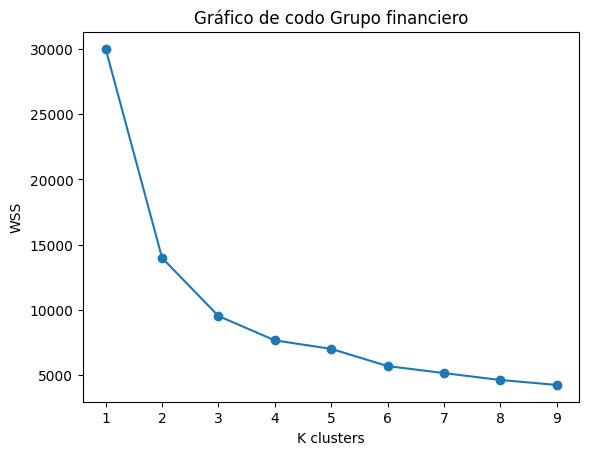

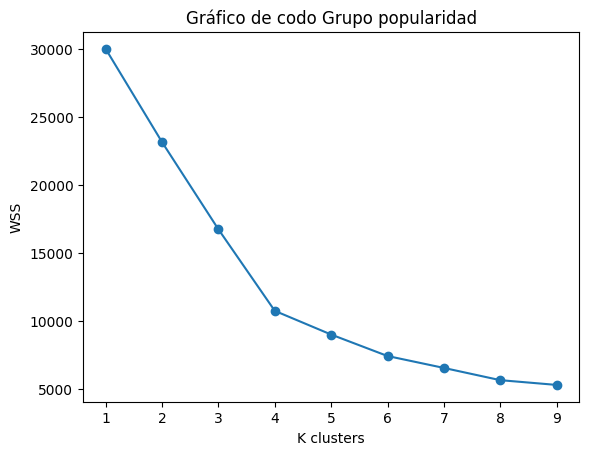

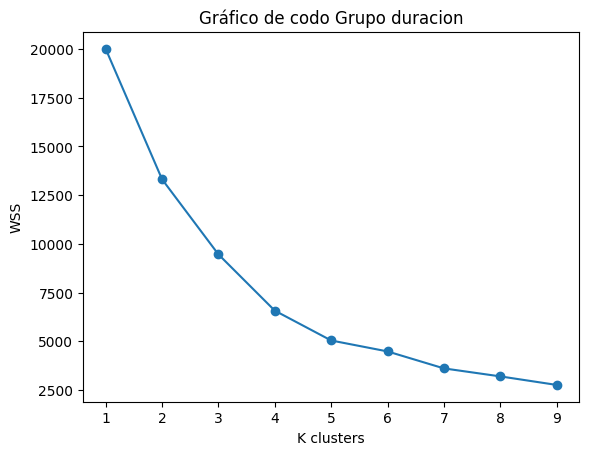

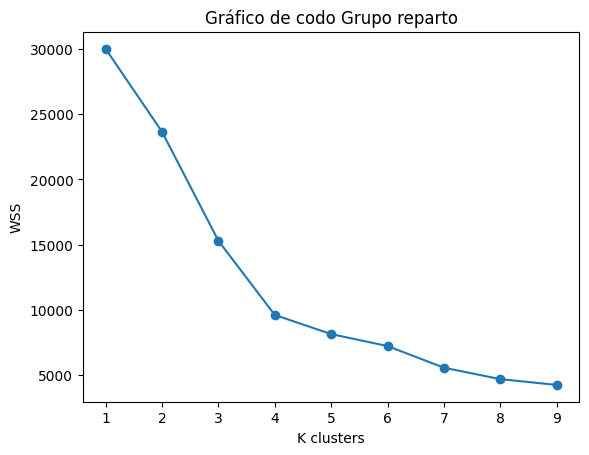

In [11]:
numeroClusters = range(1,10)

for j in range(len(Groups)):
    wcss = []
    for i in numeroClusters:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(Groups[j])
        wcss.append(kmeans.inertia_)

    plt.plot(numeroClusters, wcss, marker='o')
    plt.xticks(numeroClusters)
    plt.xlabel("K clusters")
    plt.ylabel("WSS")
    plt.title(f'Gráfico de codo Grupo {Groups_names[j]}')
    plt.show()

In [12]:
k_clusters = [3, 4, 5, 3]

### Agrupación

#### K-means

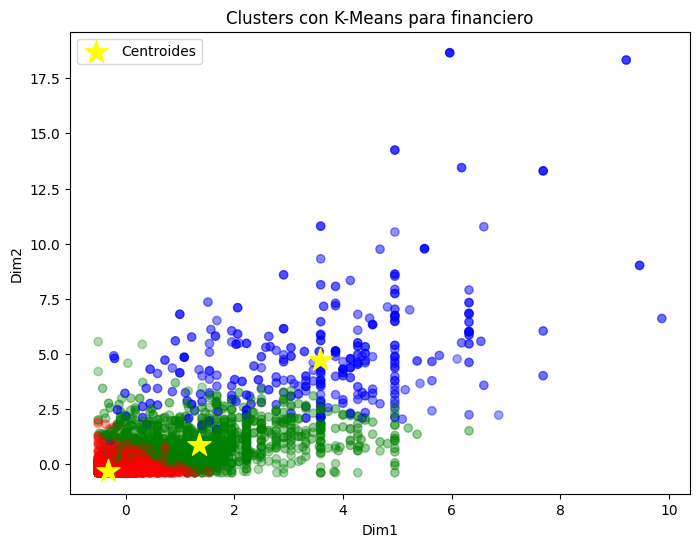

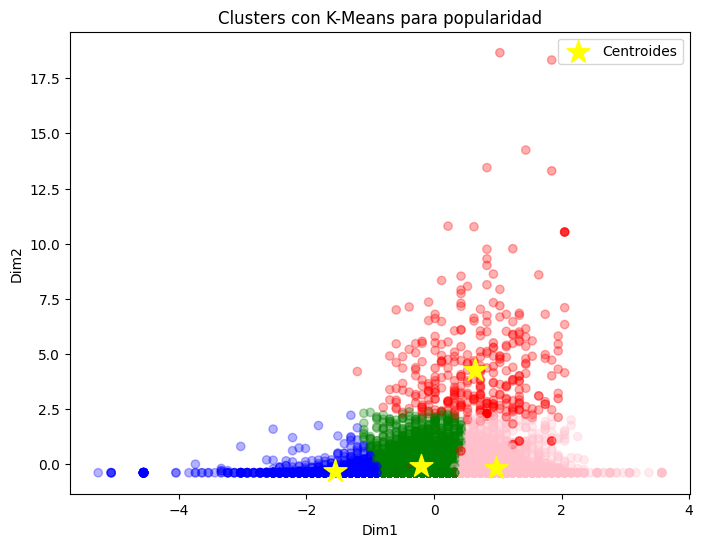

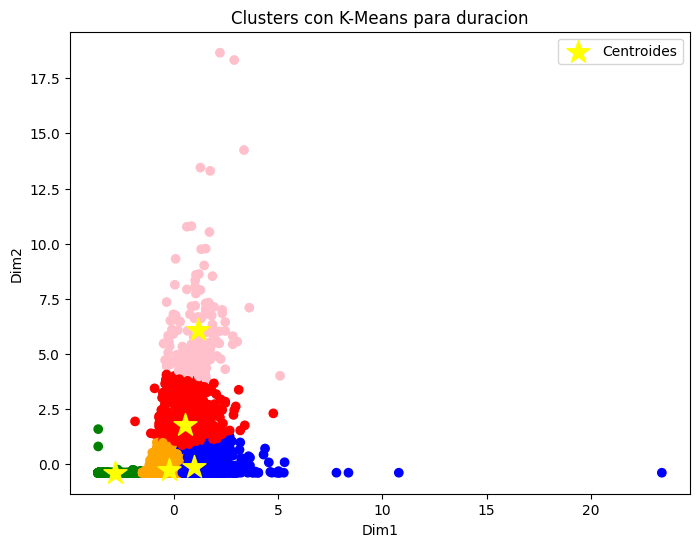

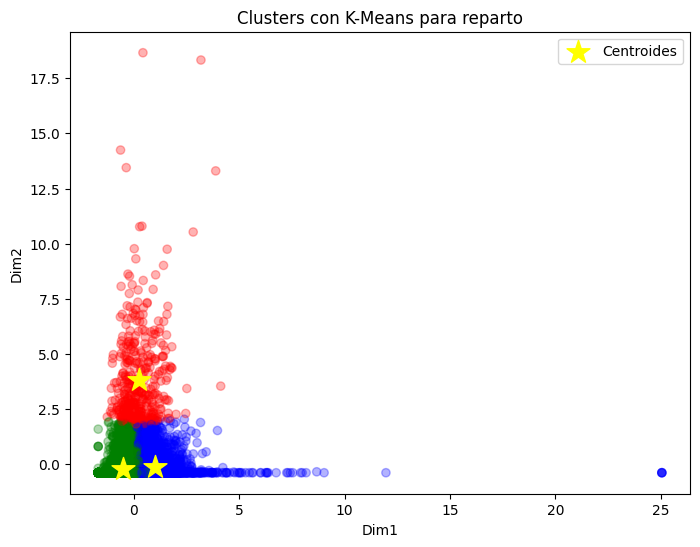

In [28]:
colores = np.array(['red', 'blue', 'green', 'pink', 'orange'])

for i, group in enumerate(Groups):
    km = KMeans(n_clusters=k_clusters[i]).fit(group)

    especies = km.labels_ 
    centroides = km.cluster_centers_

    # Ajustar la transparencia de los puntos según tercera dimensión
    if group.shape[1] > 2:
        vote_transparency = (group[:, 2] - group[:, 2].min()) / (group[:, 2].max() - group[:, 2].min())
        vote_transparency = 0.3 + vote_transparency * 0.7  # Normaliza y ajusta para evitar alpha=0
    else:
        vote_transparency = 1.0  # Transparencia fija si no hay tercera dimensión

    # Graficar los clusters
    plt.figure(figsize=(8, 6))

    plt.scatter(group[:, 0], group[:, 1], alpha=vote_transparency, c=colores[especies])
    plt.xlabel('Dim1')
    plt.ylabel('Dim2');

    # Graficar centroides en amarillo
    plt.scatter(centroides[:, 0], centroides[:, 1], s=300, c="yellow", marker="*", label="Centroides")

    plt.title(f"Clusters con K-Means para {Groups_names[i]}")
    plt.legend()
    plt.show()

#### Clustering Jerárquico

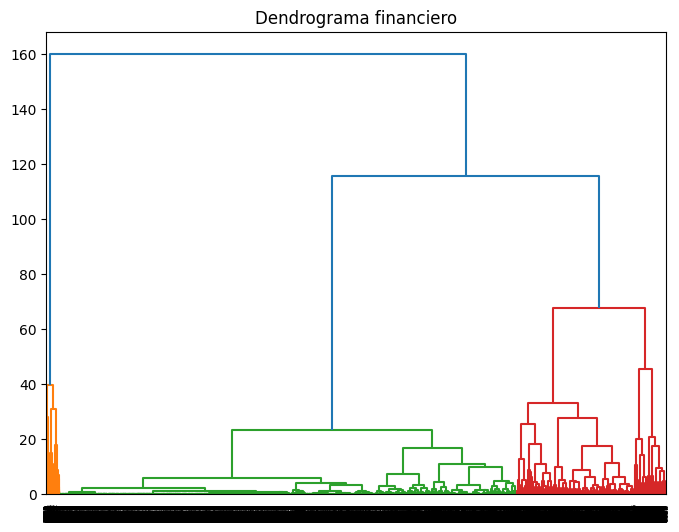

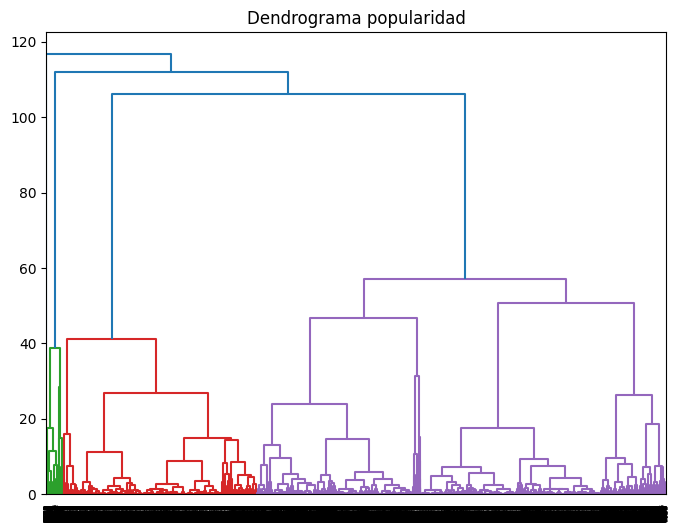

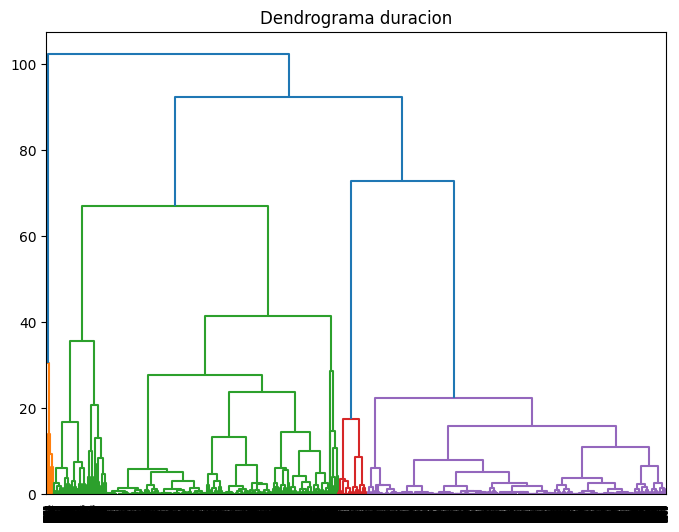

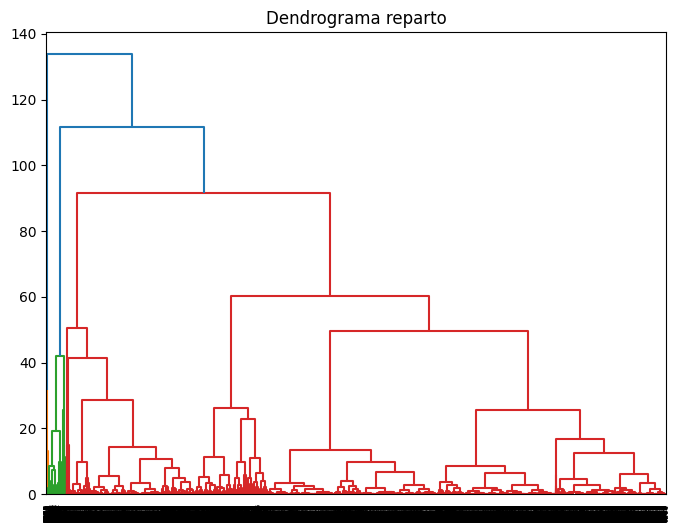

In [30]:
for i, group in enumerate(Groups):
    plt.figure(figsize=(8, 6))  # Crea una nueva figura para cada dendograma
    plt.title(f'Dendrograma {Groups_names[i]}')
    sch.dendrogram(sch.linkage(group, method='ward'))
    plt.show() 

### Análisis de Silhoutte

For n_clusters = 3 The average silhouette_score is : 0.7011339878103104


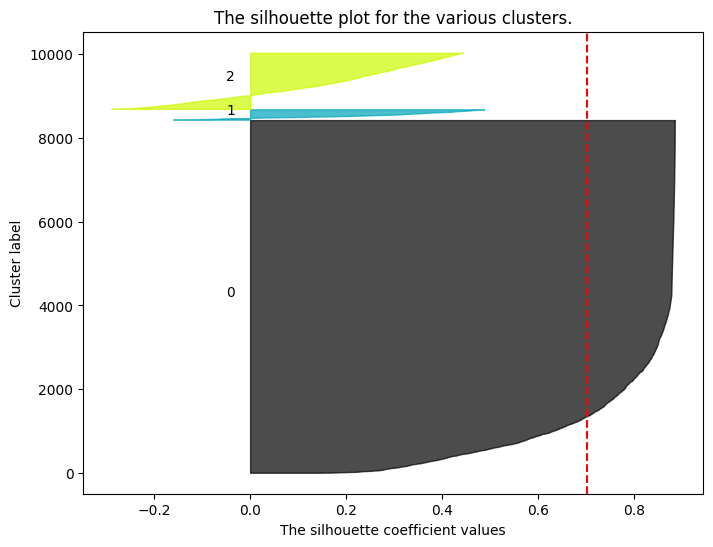

For n_clusters = 4 The average silhouette_score is : 0.4305879611842738


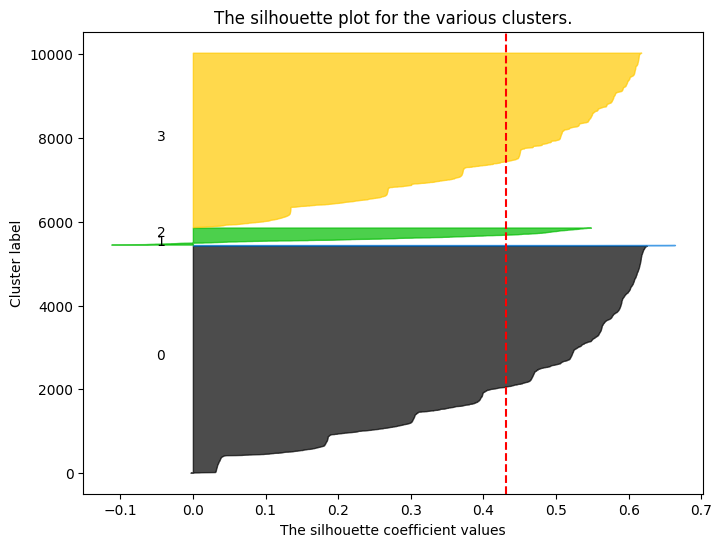

For n_clusters = 5 The average silhouette_score is : 0.5100142032255048


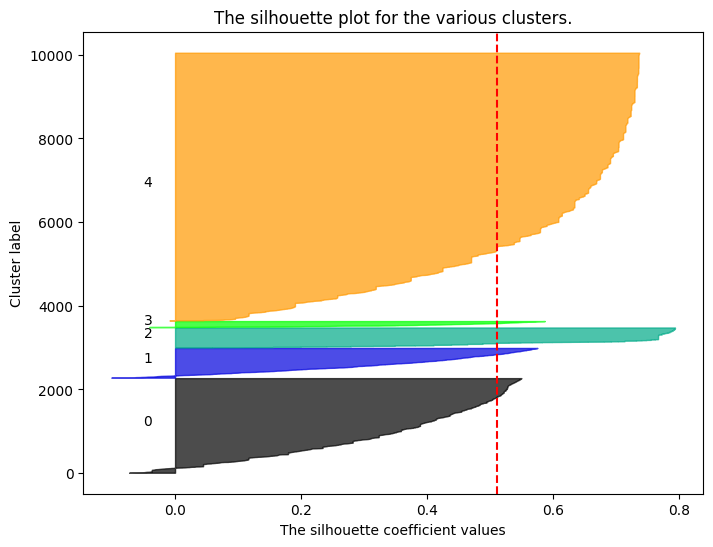

For n_clusters = 3 The average silhouette_score is : 0.695741564686533


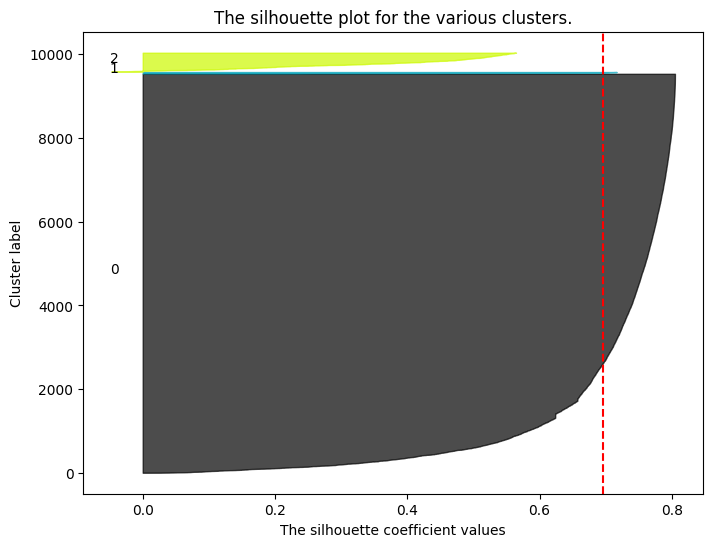

In [40]:
for i, group in enumerate(Groups):
    plt.figure(figsize=(8, 6))
    n_clusters = k_clusters[i]

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(group)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(group, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(group, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.show()

## II.	Reglas de Asociación

In [47]:
movies = pd.read_csv('movies.csv', encoding='cp1252')
print("Dataset shape:", movies.shape)

# Select fewer categorical variables to start with
categorical_columns = ['genres', 'productionCountry']  # Reduced number of columns
categoricas = movies[categorical_columns]
categoricas = categoricas.astype(object)


Dataset shape: (10000, 27)


In [48]:
# Clean and preprocess categorical data
categoricas = categoricas.fillna('Unknown')

# For genres, we'll take only the first genre if there are multiple
categoricas['genres'] = categoricas['genres'].apply(lambda x: str(x).split(',')[0] if pd.notna(x) else 'Unknown')
print("\nUnique genres:", categoricas['genres'].unique())

# For production country, take the first country
categoricas['productionCountry'] = categoricas['productionCountry'].apply(lambda x: str(x).split(',')[0] if pd.notna(x) else 'Unknown')
print("\nUnique countries:", categoricas['productionCountry'].unique())

print("\nCategorical data shape:", categoricas.shape)



Unique genres: ['Crime|Comedy' 'Action|Thriller|Crime' 'Adventure|Action|Science Fiction'
 ... 'Animation|Comedy|TV Movie' 'Drama|History|Thriller|Crime'
 'Documentary|Animation|History']

Unique countries: ['United States of America' 'Japan|United States of America'
 'Argentina|Denmark|Finland|France|Germany|Iceland|Italy|Netherlands|Norway|Sweden|United Kingdom|United States of America'
 'France' 'Germany' 'Germany|United States of America' 'United Kingdom'
 'Mexico' 'United States of America|Canada|Germany'
 'United Kingdom|United States of America' 'France|United Kingdom'
 'Austria|Switzerland|United States of America'
 'United States of America|Hong Kong|United Kingdom' 'China' 'Japan'
 'Uruguay|United States of America|Germany|Paraguay'
 'United States of America|France' 'France|Poland|Switzerland'
 'France|Poland' 'South Korea|Germany'
 'France|Ireland|Luxembourg|United Kingdom|United States of America'
 'Australia|United Kingdom|United States of America'
 'New Zealand|United S

In [49]:
# Convert the categorical data to a list of lists for apriori
records = []
for i in range(len(categoricas)):
    records.append([str(categoricas.values[i,j]) for j in range(len(categorical_columns))])

# Add some numerical variables
numerical_columns = ['voteAvg']  # Reduced to just one numerical variable for simplicity
numericas = movies[numerical_columns]

# Fill missing values with median
for col in numerical_columns:
    numericas[col] = numericas[col].fillna(numericas[col].median())

C:\Users\Fabi\AppData\Local\Temp\ipykernel_14948\1844938817.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numericas[col] = numericas[col].fillna(numericas[col].median())


In [50]:
# Create bins for vote average
numericas['voteAvg_category'] = pd.qcut(numericas['voteAvg'], 
                                       q=3, 
                                       labels=['Low_Rating', 'Medium_Rating', 'High_Rating'])

# Add the vote category to our records
for i in range(len(records)):
    records[i].append(str(numericas['voteAvg_category'].iloc[i]))

print("\nSample of processed records:")
for i in range(5):
    print(records[i])

# Generate association rules with very low support to start
reglas_asociacion = apriori(records, 
                           min_support=0.01,  # Lowered to 1%
                           min_confidence=0.5)  # Lowered to 50%
reglas = list(reglas_asociacion)



Sample of processed records:
['Crime|Comedy', 'United States of America', 'Low_Rating']
['Action|Thriller|Crime', 'Japan|United States of America', 'Medium_Rating']
['Adventure|Action|Science Fiction', 'United States of America', 'High_Rating']
['Animation|Family', 'United States of America', 'High_Rating']
['Comedy|Drama|Romance', 'United States of America', 'High_Rating']


C:\Users\Fabi\AppData\Local\Temp\ipykernel_14948\613104884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numericas['voteAvg_category'] = pd.qcut(numericas['voteAvg'],


In [51]:
print("\nNumber of rules found:", len(reglas))

if len(reglas) > 0:
    print("\nExample of first rule structure:")
    print(reglas[0])

    def inspect(output):
        results = []
        for result in output:
            if len(result[2]) > 0:  # Check if there are any rules
                for ordered_stat in result[2]:
                    if len(ordered_stat[0]) > 0 and len(ordered_stat[1]) > 0:
                        lhs = [item for item in ordered_stat[0]]
                        rhs = [item for item in ordered_stat[1]]
                        support = result[1]
                        confidence = ordered_stat[2]
                        lift = ordered_stat[3]
                        results.append((lhs, rhs, support, confidence, lift))
        return results

    # Convert rules to DataFrame
    rules_list = inspect(reglas)
    output_DataFrame = pd.DataFrame(rules_list, 
                                  columns=['Left_Hand_Side', 'Right_Hand_Side', 
                                         'Support', 'Confidence', 'Lift'])

    # Sort rules by lift
    output_DataFrame = output_DataFrame.sort_values('Lift', ascending=False)

    print("\nTop 10 rules by lift:")
    print(output_DataFrame.head(10))
else:
    print("\nNo rules found. Consider adjusting the support and confidence thresholds.")


Number of rules found: 17

Example of first rule structure:
RelationRecord(items=frozenset({'Low_Rating', 'Comedy'}), support=0.023, ordered_statistics=[OrderedStatistic(items_base=frozenset({'Comedy'}), items_add=frozenset({'Low_Rating'}), confidence=0.5227272727272727, lift=1.5279955355956525)])

Top 10 rules by lift:
                                 Left_Hand_Side Right_Hand_Side  Support  \
18  [Horror|Thriller, United States of America]    [Low_Rating]   0.0100   
10                            [Horror|Thriller]    [Low_Rating]   0.0141   
7                                 [South Korea]   [High_Rating]   0.0101   
8                                      [Horror]    [Low_Rating]   0.0154   
3                                 [Documentary]   [High_Rating]   0.0119   
6                                       [Japan]   [High_Rating]   0.0361   
15           [Comedy, United States of America]    [Low_Rating]   0.0151   
16            [Drama, United States of America]   [High_Rating]   0.0

## III.	Análisis de Componentes Principales


Test de esfericidad de Bartlett:
Chi-cuadrado: 21381.33617328001
p-valor: 0.0

Índice KMO: 0.713167589340678

Varianza explicada por componente:
   Componente  Varianza Explicada  Varianza Acumulada
0           1            0.274810            0.274810
1           2            0.114901            0.389711
2           3            0.103955            0.493667
3           4            0.100227            0.593894
4           5            0.097273            0.691167
5           6            0.096685            0.787852
6           7            0.090266            0.878118
7           8            0.071551            0.949669
8           9            0.031807            0.981476
9          10            0.018524            1.000000


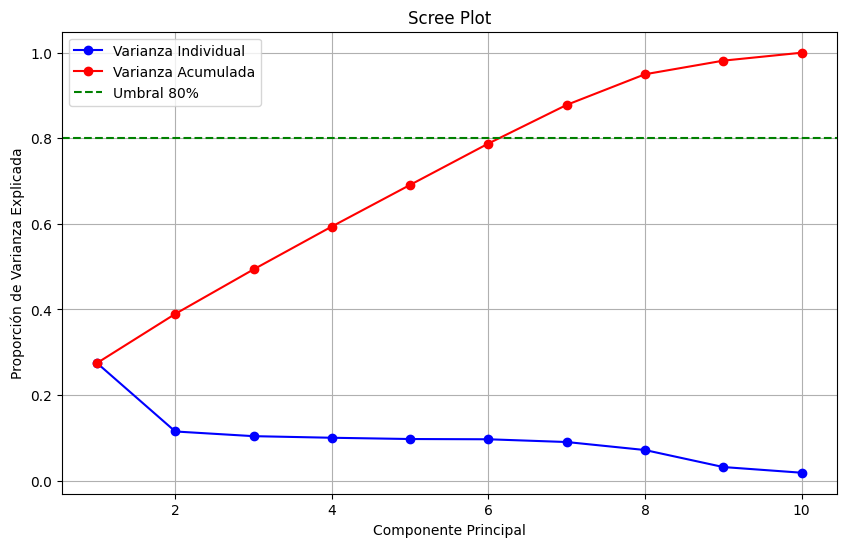


Cargas de los componentes:
                                PC1       PC2       PC3       PC4       PC5  \
budget                     0.512325 -0.150047 -0.236831  0.001453 -0.065044   
revenue                    0.537284 -0.181040 -0.110413 -0.113343 -0.083941   
runtime                    0.284490  0.486020  0.190988 -0.023941  0.043935   
popularity                 0.145452 -0.188171  0.075726 -0.277388  0.003990   
voteAvg                    0.184140  0.282935  0.753104 -0.058728  0.283518   
voteCount                  0.521470 -0.064806  0.025573 -0.101947 -0.041700   
genresAmount               0.153101 -0.139956 -0.014419  0.675588  0.380962   
productionCoAmount         0.119336  0.488891 -0.398266  0.363307  0.204612   
productionCountriesAmount -0.037235  0.329017 -0.401133 -0.545875  0.473471   
actorsAmount              -0.043034 -0.471147  0.044257 -0.096965  0.702483   

                                PC6       PC7       PC8       PC9      PC10  
budget                  

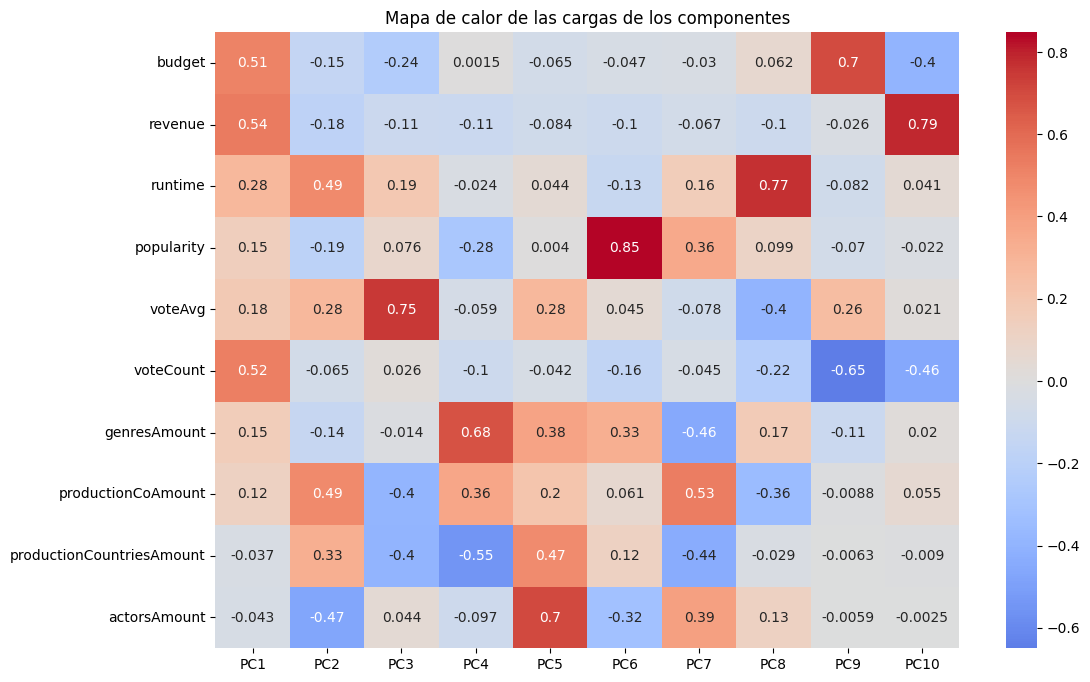

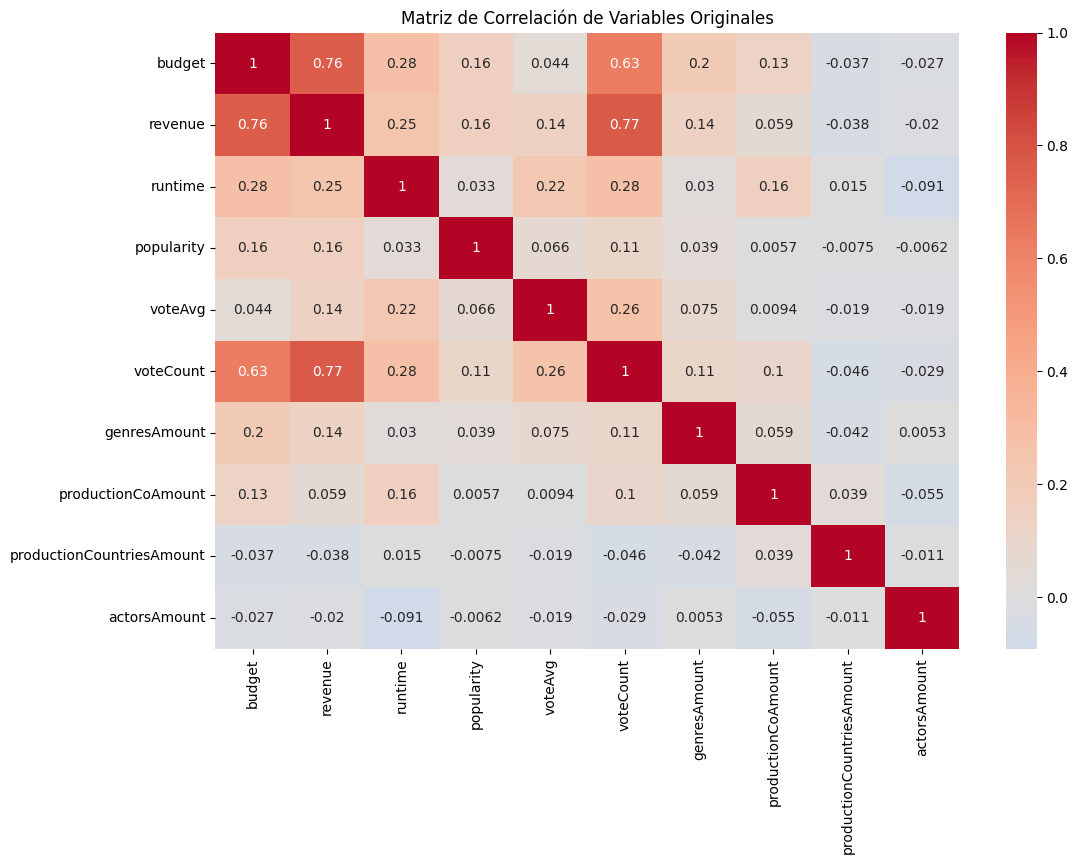


Primeras filas de los datos transformados:
        PC1       PC2       PC3           title
0 -0.555362 -0.342196 -0.196957      Four Rooms
1 -0.234058  0.255868  0.057011  Judgment Night
2  6.154641 -0.741050  1.419713       Star Wars
3  7.325555 -1.846374  0.485351    Finding Nemo
4  7.769428 -0.450482  1.621364    Forrest Gump


In [52]:
# 1. Cargar y preparar los datos
df = pd.read_csv('movies.csv', encoding='cp1252')

# Seleccionar variables numéricas
numerical_cols = ['budget', 'revenue', 'runtime', 'popularity', 'voteAvg', 'voteCount', 
                 'genresAmount', 'productionCoAmount', 'productionCountriesAmount', 'actorsAmount']
X = df[numerical_cols].copy()

# Manejar valores faltantes
for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

# 2. Verificar la adecuación de los datos para PCA
# Test de esfericidad de Bartlett
chi_square, p_value = calculate_bartlett_sphericity(X)
print("Test de esfericidad de Bartlett:")
print(f"Chi-cuadrado: {chi_square}")
print(f"p-valor: {p_value}")

# Índice KMO
kmo_all, kmo_model = calculate_kmo(X)
print(f"\nÍndice KMO: {kmo_model}")

# 3. Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Realizar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 5. Analizar la varianza explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Crear DataFrame con varianza explicada
variance_df = pd.DataFrame({
    'Componente': range(1, len(explained_variance) + 1),
    'Varianza Explicada': explained_variance,
    'Varianza Acumulada': cumulative_variance
})
print("\nVarianza explicada por componente:")
print(variance_df)

# 6. Visualizar scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'ro-')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Scree Plot')
plt.axhline(y=0.8, color='g', linestyle='--')
plt.legend(['Varianza Individual', 'Varianza Acumulada', 'Umbral 80%'])
plt.grid(True)
plt.show()

# 7. Analizar las cargas de los componentes
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(numerical_cols))],
    index=numerical_cols
)
print("\nCargas de los componentes:")
print(loadings)

# 8. Visualizar mapa de calor de las cargas
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Mapa de calor de las cargas de los componentes')
plt.show()

# 9. Analizar correlaciones entre variables originales
correlation_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Variables Originales')
plt.show()

# 10. Transformar los datos originales
# Seleccionar número de componentes basado en varianza explicada (por ejemplo, 3 componentes)
n_components = 3
pca_final = PCA(n_components=n_components)
X_transformed = pca_final.fit_transform(X_scaled)

# Crear DataFrame con los componentes principales
pca_df = pd.DataFrame(
    X_transformed,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# Añadir información relevante del dataset original
pca_df['title'] = df['title']
print("\nPrimeras filas de los datos transformados:")
print(pca_df.head())